In [30]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 8: Time series
**Due date: See the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html).**

## Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

## Submission instructions
<hr>
rubric={points:4}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **You may work on this assignment in a group (group size <= 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Upload the .ipynb file to Gradescope.
- **If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb.** 
- Make sure that your plots/output are rendered properly in Gradescope.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. We will be forcasting average avocado price for the next week. 

In [32]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [33]:
df.shape

(18249, 13)

In [34]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [35]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [36]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [37]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the Rain is Australia dataset from lecture, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

In [38]:
df.sort_values(by=["region", "Date"]).reset_index(drop=True).head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
3,2015-01-11,1.77,1182.56,39.00,305.12,0.00,838.44,838.44,0.00,0.0,organic,2015,Albany
4,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany


In [39]:
df.sort_values(by=["type", "Date"]).reset_index(drop=True).head()


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
2,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington
3,2015-01-04,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.0,conventional,2015,Boise
4,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston


Sorting the data by "region" then "date" reveals that each region has two data observations taken for every date - one observation for type "organic" and one for type "conventional". Based on this observation, there are different time series for each category in "regions" and for the two categories in "type".

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Type your answer here, replacing this text._

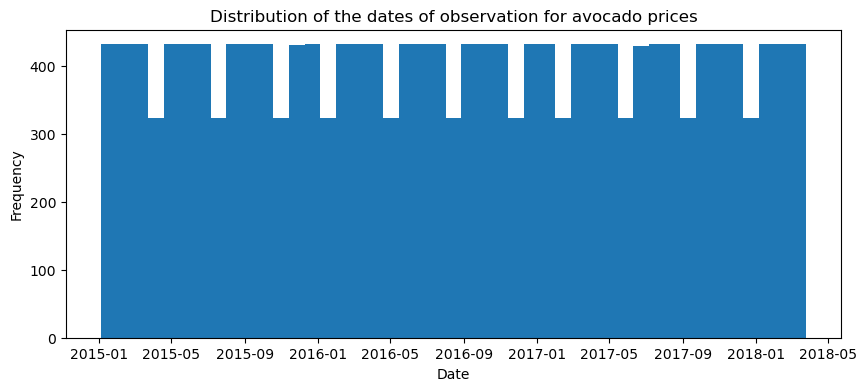

In [40]:
plt.figure(figsize=(10,4))
plt.hist(df["Date"], bins=45)
plt.title("Distribution of the dates of observation for avocado prices")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.show()

Based on the above histogram showing the distribution of dates for when avocado price are observed, there is a consistent pattern for when observations are made each month. However, the dates of observation are not equally spaced, as there is a large gap between the 9th bin of the current month and 1st bin of the next month.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain is Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Type your answer here, replacing this text._

In [41]:
df.region.drop_duplicates()


0                 Albany
0                Atlanta
0    BaltimoreWashington
0                  Boise
0                 Boston
0       BuffaloRochester
0             California
0              Charlotte
0                Chicago
0       CincinnatiDayton
0               Columbus
0          DallasFtWorth
0                 Denver
0                Detroit
0            GrandRapids
0             GreatLakes
0     HarrisburgScranton
0    HartfordSpringfield
0                Houston
0           Indianapolis
0           Jacksonville
0               LasVegas
0             LosAngeles
0             Louisville
0      MiamiFtLauderdale
0               Midsouth
0              Nashville
0       NewOrleansMobile
0                NewYork
0              Northeast
0     NorthernNewEngland
0                Orlando
0           Philadelphia
0          PhoenixTucson
0             Pittsburgh
0                 Plains
0               Portland
0      RaleighGreensboro
0        RichmondNorfolk
0                Roanoke


We think the regions are overlapping becuase there are some regions that are cities and others that are states. Moreover, there are categories such as "West" and "TotalUS" that definitely encompass other categories such as "Boise", which is in the "TotalUS".

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from Lecture 20, with some improvements.

In [42]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    TODO: could/should simplify this function by using `df.shift()`
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [43]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [44]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [45]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points:4}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Type your answer here, replacing this text._

In [46]:
y_true_train = df_train["AveragePriceNextWeek"]
y_true_test = df_test["AveragePriceNextWeek"]

In [47]:
y_pred_train = df_train["AveragePrice"]
y_pred_test = df_test["AveragePrice"]

In [48]:
train_r2 = r2_score(y_true_train, y_pred_train)
print("Train score:", train_r2)

Train score: 0.8285800937261841


In [49]:
test_r2 = r2_score(y_true_test, y_pred_test)
print("Test score:", test_r2)

Test score: 0.7631780188583048


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import Ridge

In [79]:
# 1. sort by date 
# Ignored the multiple time series and just OHE the location
train_df_ordered = df_train.sort_values(by="Date")
y_train_ordered = train_df_ordered["AveragePriceNextWeek"]

In [80]:
train_df_ordered.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
13858,2015-01-04,0.94,461607.33,244152.26,165299.33,15302.75,36852.99,30884.29,5595.00,373.7,conventional,2015,SanDiego,0.82
1352,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston,1.10
13689,2015-01-04,1.33,9213.49,3727.52,4327.52,0.00,1158.45,1158.45,0.00,0.0,organic,2015,Sacramento,1.27
13520,2015-01-04,1.05,430138.88,110693.69,270107.61,9737.50,39600.08,39600.08,0.00,0.0,conventional,2015,Sacramento,1.09


In [81]:
# 2. Preprocess data
# Code from lecture 20
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["AveragePriceNextWeek"]
    y_test = test_df["AveragePriceNextWeek"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [82]:
numeric_features = ["AveragePrice"]
categorical_features = ["region", "type", "year"]
drop_features = ["Date", "Total Volume","4046", "4225", "4770", "Total Bags", "Small Bags", "Large Bags", "XLarge Bags"]
target = ["AveragePriceNextWeek"]

In [83]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features,
    categorical_features,
    drop_features,
    target
)

In [84]:
# Fitting Ridge model
y_train = df_train["AveragePriceNextWeek"]
y_test = df_test["AveragePriceNextWeek"]

r_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
r_pipe.fit(df_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['AveragePrice']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['region', 'type', 'year']),
                                                 ('drop', 'drop',
                                                  ['Date', 'Total Volume',
                                                   '4046', '4225', '4770',
                                                   'Total Bags', 'Small Bags',
                                                   'Large Bags',
                                                   'XLarge Bags'])])),
                ('ridge', Ridge(max_iter=1000))])

In [85]:
cross_val_score(r_pipe, train_df_ordered, y_train_ordered, cv=TimeSeriesSplit()).mean()

0.8051621626258887

In [98]:
#3. Encoding time as an number - TODO?
# Code adapted from lecture 20

first_day = df_train["Date"].min()

df_train = df_train.assign(
    Days_since=df_train["Date"].apply(lambda x: (x - first_day).days)
)
df_test = df_test.assign(
    Days_since=df_test["Date"].apply(lambda x: (x - first_day).days)
)

In [103]:
X_train_enc.head()

,Days_since,AveragePrice,region_Albany,region_Atlanta,region_BaltimoreWashington,region_Boise,region_Boston,region_BuffaloRochester,region_California,region_Charlotte,...,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,type_conventional,type_organic,year_2015,year_2016,year_2017
0,-1.719903,-0.432512,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.695677,-0.383676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-1.671451,-0.554604,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-1.647225,-0.823205,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-1.622999,-0.994133,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: very short answer questions

Each question is worth 2 points.

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:4}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

<div class="alert alert-warning">

Solution_2.1
    
</div>

1. For a clinical study, you are collecting blood samples from a patient everyutime they come in for a checkup. It is unlikely that the patient will come for a checkup exactly one year after the previous checkup. Also, it is common for people to skip a checkup some years or delay when they go in for a checkup. This leads to ounqueal spaces between time points.

2. Creating lagged versions of the features would not make much sense with unequal timed point. Lag based features assume that outcomes from previous time points can help predict the next time point. Unequal spaced points create inconsistency bewteen each time point that make it difficult to use the previous time point to predict the next one.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Survival analysis
rubric={points:6}

The following questions pertain to Lecture 21 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
4. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

![](img/eva-well-done.png)